# Validation/Verification & Performance comparison for LOGIC gates with multiple hidden layers and multiple neurons

## Set ncores for my Implementation (needs to be before importing numpy)

In [1]:
nThreads = 8

### For Numpy MKL

In [2]:
! export OMP_NUM_THREADS=8 MKL_NUM_THREADS=8 NUMEXPR_NUM_THREADS=8
! export TF_NUM_INTEROP_THREADS=8

## Import stuff

In [2]:
import numpy as np
# print(np.__version__)
from autograd import numpy as anp
from autograd import grad, elementwise_grad, jacobian
from IPython import display
import time
from tqdm.notebook import tqdm
import numexpr as ne
from opt_einsum import contract, contract_expression
from numba import vectorize,jit,njit,prange,set_num_threads,get_num_threads 
from nnv import NNV
import matplotlib.pyplot as plt
from operator import add
# from numpy.core.umath_tests import inner1d


# import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.python.eager import context


import torch, torchvision
rng = np.random.default_rng()
import time
from timeit import default_timer as timer

## Set nthreads for my PyTorch and tensorflow

### For tensorflow

In [4]:
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_intra_op_parallelism_threads(nThreads)
tf.config.threading.set_inter_op_parallelism_threads(nThreads)
print(tf.config.threading.get_inter_op_parallelism_threads())
print(tf.config.threading.get_intra_op_parallelism_threads())

8
8


2021-12-13 00:56:52.627805: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-13 00:56:52.628191: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


### For PyTorch

In [5]:
torch.set_num_threads(nThreads)
print(torch.get_num_threads())

8


## Check if NumPy is linked with MKL or not

In [3]:
np.show_config()

blas_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/admin/opt/anaconda3/envs/performance/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/admin/opt/anaconda3/envs/performance/include']
blas_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/admin/opt/anaconda3/envs/performance/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/admin/opt/anaconda3/envs/performance/include']
lapack_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/admin/opt/anaconda3/envs/performance/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/admin/opt/anaconda3/envs/performance/include']
lapack_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/admin/opt/anaconda3/envs/performance/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include

## Start with the common stuff

In [506]:
nInputs = 784
nSamples = nBatch = 32
nOutputs = 1
neurons_per_layer = [700,700,10]#[500,500,500,500,1]#[ 100,4,1] #[100,100,100,100,100,100,1]#[100,100,100,100,1]
activation_func_names = ['Sigmoid','Sigmoid', 'Softmax']#['sigmoid', 'sigmoid', 'sigmoid']#['sigmoid', 'sigmoid','sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid']#['sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid']
nLayers = len(neurons_per_layer)
eeta = 0.5
nEpochs=10
nBatches = 0
batchSize = 200#nSamples
totSamples = 0

#### Activation function dictionary for all the frameworks

In [507]:
# act_func_dict = {'Sigmoid':Sigmoid,'ReLU':ReLU,'ELU':ELU, 'Hardshrink' : Hardshrink,'Hardsigmoid':Hardsigmoid,\
#                  'Hardtanh':Hardtanh,'Hardswish':Hardswish,'LeakyReLU':LeakyReLU,'LogSigmoid':LogSigmoid,\
#                  'Tanh':Tanh,'Softmax':Softmax,'Softmin':Softmin,'LogSoftmax':LogSoftmax,'Mish':Mish,\
#                  'Swish':Swish,'Exponential':Exponential}

act_func_dict = {'Sigmoid':Sigmoid,'ReLU':ReLU,'Softmax':Softmax}
act_func_grad_dict = {'Sigmoid':Sigmoid_grad,'ReLU':ReLU_grad,'Softmax':Softmax_grad}

act_func_dict_PyTorch = {'Sigmoid':torch.nn.Sigmoid(),'ReLU':torch.nn.ReLU(),'ELU':torch.nn.ELU(), 'Hardshrink' : torch.nn.Hardshrink(),'Hardsigmoid':torch.nn.Hardsigmoid(),\
                 'Hardtanh':torch.nn.Hardtanh(),'Hardswish':torch.nn.Hardswish(),'LeakyReLU':torch.nn.LeakyReLU(),'LogSigmoid':torch.nn.LogSigmoid(),\
                 'Tanh':torch.nn.Tanh(),'Softmax':torch.nn.Softmax(dim=1),'Softmin':torch.nn.Softmin(dim=1),'LogSoftmax':torch.nn.LogSoftmax()}
act_func_dict_tensorflow = {'Sigmoid':'sigmoid','Softmax':'softmax','ReLU':'relu','LeakyReLU':'leakyrelu'}
# act_func_dict_tensorflow = {'Sigmoid':sigmoid,'ReLU':ReLU,'ELU':ELU, 'Hardshrink' : Hardshrink,'Hardsigmoid':Hardsigmoid,\
#                  'Hardtanh':Hardtanh,'Hardswish':Hardswish,'LeakyReLU':LeakyReLU,'LogSigmoid':LogSigmoid,\
#                  'Tanh':Tanh,'Softmax':Softmax,'Softmin':Softmin,'LogSoftmax':LogSoftmax,'Mish':Mish,\
#                  'Swish':Swish,'Exponential':exponential}



## Visualize 

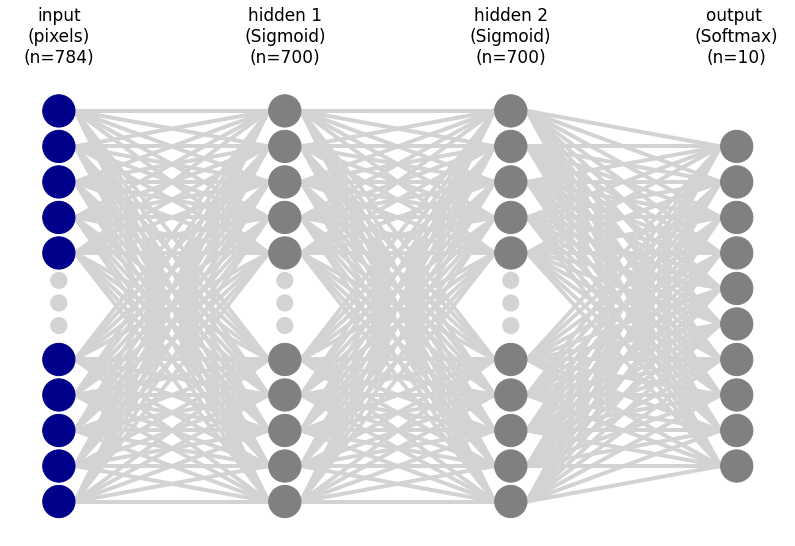

In [508]:
plt.rcParams["figure.figsize"] = (14,10)
# Input layer
layersList = [{"title":"input\n(pixels)"+"\n(n="+str(nInputs)+")", "units": nInputs, "color": "darkBlue"}]
# Hidden layers
if nLayers>1:
    for i in range(nLayers-1):
        layersList.append({"title":"hidden "+str(i+1)+"\n("+activation_func_names[i]+")"+"\n(n="+str(neurons_per_layer[i])+")", "units": neurons_per_layer[i]})
        

# Output layers
layersList.append({"title":"output \n("+activation_func_names[nLayers-1]+")"+"\n(n="+str(neurons_per_layer[nLayers-1])+")", "units": neurons_per_layer[nLayers-1]})

NNV(layersList,max_num_nodes_visible=10, node_radius=5, spacing_layer=60, font_size=17).render()
plt.rcParams["figure.figsize"] = (9,6)

## Set inputs

Use torchvision to get the dataset, as well as form the input and output matrices for the learning.

In [509]:
fname = 'MNIST'

### Download and initialize datasets
TrainDS_orig = torchvision.datasets.MNIST(fname, train=True, download=True)
TestDS_orig = torchvision.datasets.MNIST(fname, train=False)

Plot few examples of the data

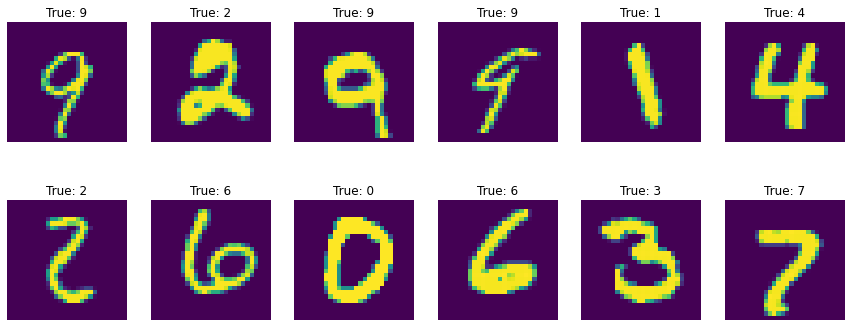

In [510]:
### Plot examples
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(15., 6.))
for axes_row in axes:
    for ax in axes_row:
        test_index = rng.integers(0, len(TestDS_orig))
        image, orig_label = TestDS_orig[test_index]
        ax.set_axis_off()
        ax.imshow(image)
        ax.set_title('True: %i' % orig_label)

Currently the dataset is such that each element of `TrainDS_orig` returns an image and the output label(the digit)

<PIL.Image.Image image mode=L size=28x28 at 0x155D63A10>
5


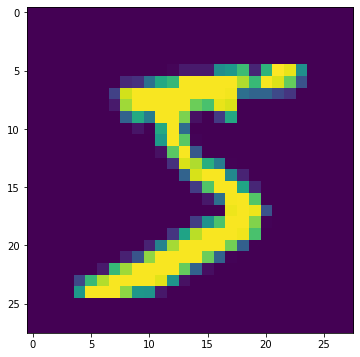

In [511]:
image, orig_label = TrainDS_orig[0]
print(image)
print(orig_label)
plt.imshow(image)

We can convert each image in the data to a 28x28 2d-array or a 784x1 1d-array manually as follows

In [512]:
imgData = np.array(image.getdata()) # Get data values
imgData = imgData/imgData.max() # Renormalize
print(imgData.shape)
imgData = np.reshape(imgData, [28,28]) # Reshape
print(imgData)
print(imgData.shape)

(784,)
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        

But alternatively, we can just use PyTorch to do it, because we would want to have the same order of batches and everything to keep the benchmark consistent and comparable.

Also, instead of the output label being just a digit, it would be better if it is a 10x1 array with each element giving the probability of the classification being a digit in 0-9.

In [513]:
### Define the label transform from an integer to a set of probabilities
def target_transform(inlabel):
    newlabel = torch.zeros(10)
    newlabel[inlabel] = 1.
    return newlabel

### Reinitialize datasets with the transforms
TrainDS = torchvision.datasets.MNIST(fname, train=True, download=True,
            target_transform=target_transform, transform=torchvision.transforms.ToTensor())
TestDS = torchvision.datasets.MNIST(fname, train=False,
            target_transform=target_transform, transform=torchvision.transforms.ToTensor())

### Initialize DataLoaders as PyTorch convenience
TrainDL = torch.utils.data.DataLoader(TrainDS, shuffle=True, batch_size=batchSize)
TestDL = torch.utils.data.DataLoader(TestDS, batch_size=1000)

The `TrainDL` dataloader object holds everything we need (as tensors). We would now use it to get the input data and the output data as numpy 2d arrays for our implementation as well as for tf.eras

In [514]:
totSamples = 0
for inp, labels in TrainDL:
    totSamples = totSamples+1
nBatches = totSamples
print('Total no. of batches: ', totSamples)

totSamples = totSamples*batchSize
print('Total no. of training samples: ', totSamples)

Total no. of batches:  300
Total no. of training samples:  60000


## Actually create inputs and outputs

Create total inputs matrix and the total outputs matrix, which hold all the training data 

In [515]:
inputs = np.zeros((totSamples,784))
outputs = np.zeros((totSamples, 10))

i = 0
for inp, labels in TrainDL:
    offset = i*batchSize
    inputs[offset:offset + batchSize,:] = np.reshape(inp, (batchSize,784))
    outputs[offset:offset + batchSize,:] = labels

## Set float32 precision

In [516]:
inputs = inputs.astype('float32')
outputs = outputs.astype('float32')
print(inputs.dtype)
print(outputs.dtype)

float32
float32


# Keras implementation

In the following we have to be careful and change the network nodes, and layers manually. 

TODO: Make the neural network be generated in a loop automatically using the parameters already defined.

In [517]:
# # define the keras model
# model = Sequential()
# model.add(Dense(100, input_dim=2, activation='sigmoid', use_bias=True))
# model.add(Dense(100, activation='sigmoid', use_bias=True))
# model.add(Dense(100, activation='sigmoid', use_bias=True))
# model.add(Dense(100, activation='sigmoid', use_bias=True))
# model.add(Dense(1, activation='sigmoid', use_bias=True))

# model.summary()

## Make the neural network programatically

In [518]:
# define the keras model
model = Sequential()
# First Hidden layer
model.add(Dense(neurons_per_layer[0], input_dim=nInputs, activation=act_func_dict_tensorflow[activation_func_names[0]], use_bias=True))

if nLayers>1:
    # Hidden layers
    for i in range(nLayers-2):
        model.add(Dense(neurons_per_layer[i], activation=act_func_dict_tensorflow[activation_func_names[i]], use_bias=True))
    # Output layer
    model.add(Dense(neurons_per_layer[nLayers-1], activation=act_func_dict_tensorflow[activation_func_names[nLayers-1]], use_bias=True))
    
model.summary()
    

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 700)               549500    
_________________________________________________________________
dense_28 (Dense)             (None, 700)               490700    
_________________________________________________________________
dense_29 (Dense)             (None, 10)                7010      
Total params: 1,047,210
Trainable params: 1,047,210
Non-trainable params: 0
_________________________________________________________________


## Check the initial weights and biases for each layer

Note how the weights matrix is not 4x2 but rather 2x4

In [519]:
for i in range(nLayers):
    print('\n Weights for layer ',i+1)
    print(model.layers[i].get_weights()[0])
    print('\n Biases for layer ',i+1)
    print(model.layers[i].get_weights()[1])
# model.layers[0].get_biases()


 Weights for layer  1
[[-0.02419456 -0.03639057 -0.0261796  ...  0.04830931 -0.02347935
  -0.04591497]
 [-0.01163159  0.0452029   0.03212485 ...  0.00063124  0.02467095
   0.02918391]
 [ 0.02475894  0.05432296 -0.01673191 ...  0.05744867  0.0040729
  -0.00739492]
 ...
 [ 0.03824916 -0.04163023 -0.05381735 ...  0.00549434  0.00690878
   0.02302977]
 [ 0.0274745   0.02325216 -0.01957689 ...  0.05184112  0.05925937
  -0.01469268]
 [-0.05233389 -0.03995981 -0.03536157 ... -0.03123657  0.04053029
  -0.03318025]]

 Biases for layer  1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0

## Save the weights generated by tf.keras and use them for our implementation as well

In [520]:
weightsOriginal = []
biasesOriginal = []


for i in range(nLayers):
    weightsOriginal.append(model.layers[i].get_weights()[0].T)
    biasesOriginal.append(model.layers[i].get_weights()[1].T)

print('Weights matrices: ',weightsOriginal)
print('Biases: ',biasesOriginal)

Weights matrices:  [array([[-0.02419456, -0.01163159,  0.02475894, ...,  0.03824916,
         0.0274745 , -0.05233389],
       [-0.03639057,  0.0452029 ,  0.05432296, ..., -0.04163023,
         0.02325216, -0.03995981],
       [-0.0261796 ,  0.03212485, -0.01673191, ..., -0.05381735,
        -0.01957689, -0.03536157],
       ...,
       [ 0.04830931,  0.00063124,  0.05744867, ...,  0.00549434,
         0.05184112, -0.03123657],
       [-0.02347935,  0.02467095,  0.0040729 , ...,  0.00690878,
         0.05925937,  0.04053029],
       [-0.04591497,  0.02918391, -0.00739492, ...,  0.02302977,
        -0.01469268, -0.03318025]], dtype=float32), array([[ 0.045945  , -0.05400587,  0.01867947, ..., -0.01506453,
        -0.01779313,  0.03648485],
       [-0.0509551 , -0.02825987,  0.00541856, ...,  0.02847423,
         0.05764167, -0.04098984],
       [ 0.05921181,  0.03913921,  0.01493968, ...,  0.00455093,
         0.05661488,  0.02135816],
       ...,
       [-0.00608244,  0.02340353,  0.04

## Compile model

In [521]:
# compile the keras model

# In the following manner we can't set the learning rate of the optimizer
# model.compile(loss='mse', optimizer='sgd', metrics=['mse'])

# So use the following instead
model.compile(loss='mse', optimizer=optimizers.SGD(learning_rate=eeta), metrics=['mse'])

## Forward feed

In [ ]:
model.evaluate(inputs, outputs, batch_size=batchSize)

## Does tf.model.evaluate change the weights and biases?

In [ ]:
for i in range(nLayers):
    print('\n Weights for layer ',i+1)
    print(model.layers[i].get_weights()[0])
    print('\n Biases for layer ',i+1)
    print(model.layers[i].get_weights()[1])
# model.layers[0].get_biases()

From the above, we can be sure that it does not change the weights and biases

## Fit 1 epoch  (forward feed, backpropagation, updating the weights, biases)

Let us just try to see and compare the error after just 1 epoch. 

We should expect the model to perform forward feed, calculate loss/error,
perform backpropagation,
and adjust the weights and biases based on the learning rate.

Note: Batch size=4 indicates that we are using all the training data(examples) and therefore this is the equivalent of my own implementation as I don't have stochastic/minibatch gradient descent implementation yet.

References: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

In [1602]:
# fit the keras model on the dataset
model.fit(inputs, outputs, epochs=1, batch_size=batchSize)

Train on 4 samples
4/4 [==============================] - 1s 152ms/sample - loss: 0.2624 - mse: 0.2624


## Now the weights and biases must have been updated

In [1603]:
for i in range(nLayers):
    print('\n Weights for layer ',i+1)
    print(model.layers[i].get_weights()[0])
    print('\n Biases for layer ',i+1)
    print(model.layers[i].get_weights()[1])
# model.layers[0].get_biases()


 Weights for layer  1
[[-0.01360707 -0.072459   -0.04958601 ...  0.06592553  0.03241978
   0.04063641]
 [ 0.06719163  0.03816348  0.02243045 ... -0.0224451   0.02069772
   0.0305414 ]]

 Biases for layer  1
[ 5.13154373e-06 -1.45216165e-06  8.80169864e-06 -1.81117066e-05
  9.27395649e-06  5.69616577e-06  2.29282232e-05 -5.71785904e-06
  1.62495962e-05 -2.61633722e-05  1.60899458e-06 -4.57588567e-06
  8.47034426e-06 -2.84121484e-06 -8.26362702e-06  4.89639524e-06
 -1.04887531e-05 -3.14810459e-05  3.04290334e-05  2.13627573e-05
  2.51649681e-07 -1.72452201e-05 -6.77040543e-06  1.57926406e-05
 -1.02369595e-05 -4.10934172e-06  3.66717722e-06  2.49563655e-05
 -1.45420086e-06  5.35537265e-06 -1.69482573e-05  7.92678293e-06
  1.53422916e-05 -1.69861923e-05 -1.22480806e-05  1.89330949e-05
  7.04207514e-06  2.39270412e-05 -3.12056654e-05 -5.68973155e-06
  2.93177673e-05 -3.23844179e-05 -1.41119153e-05 -6.93314723e-06
 -8.81941469e-06  1.55205043e-06 -1.00220559e-05 -2.19976459e-06
 -4.09986642

## Now let us do a forward feed again and calculate the loss/error

Note: Batch size=4 indicates that we are using all the training data(examples) and therefore this is the equivalent of my own implementation as I don't have stochastic/minibatch gradient descent implementation yet.

References: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

In [1604]:
out = model.evaluate(inputs, outputs, batch_size=batchSize)
print(out)

4/1 [========================================================================================================================] - 0s 1ms/sample - loss: 0.4993 - mse: 0.4993
[0.4993361234664917, 0.49933612]


### The above result, compares well with the result from my own implementation (when biases are updated independently)

## Now let us let the model train for 10^4 epochs

Note: Batch size=4 indicates that we are using all the training data(examples) and therefore this is the equivalent of my own implementation as I don't have stochastic/minibatch gradient descent implementation yet.

References: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

In [522]:
%%time
# fit the keras model on the dataset
# history = model.fit(tf.convert_to_tensor(inputs, dtype=tf.float32), tf.convert_to_tensor(outputs, dtype=tf.float32), epochs=nEpochs, batch_size=batchSizenSamples, verbose=0)
history = model.fit(inputs, outputs, epochs=nEpochs, batch_size=batchSize, verbose=0)

CPU times: user 3min 22s, sys: 1min 11s, total: 4min 34s
Wall time: 50.4 s


Turns out that this was quite slow. At first, I thought that the problem was that it was printing at each epoch. So I set the verbose=0 (silent). But still, it was incredibly slow compared to my implementation as well as PyTorch, even though we used own for loop in both the cases.

In [523]:
history.history

{'loss': [0.010337538955112299,
  0.010266624909515182,
  0.01026659034192562,
  0.010266566264132658,
  0.010266559791440765,
  0.01026651222569247,
  0.010266542096311847,
  0.010266518394152324,
  0.01026649197563529,
  0.010266480026766658],
 'mse': [0.010337543,
  0.01026662,
  0.0102665955,
  0.010266565,
  0.010266562,
  0.01026651,
  0.010266538,
  0.010266512,
  0.010266488,
  0.010266476]}

## Now also let us have a look at the predictions for the sake of the tutorial

In [524]:
# make probability predictions with the model
predictions = model.predict(inputs)
print(predictions)

[[0.10286685 0.10086538 0.1005224  ... 0.1022777  0.10242207 0.10035142]
 [0.101004   0.10309841 0.09697136 ... 0.10070726 0.10168342 0.1008905 ]
 [0.10125784 0.09980379 0.10315415 ... 0.09849249 0.10062153 0.09848891]
 ...
 [0.10036778 0.10018489 0.0997692  ... 0.0999214  0.09974816 0.09976154]
 [0.10036775 0.10018493 0.09976918 ... 0.09992141 0.09974816 0.09976149]
 [0.10036775 0.10018493 0.09976918 ... 0.09992141 0.09974816 0.09976149]]


## We have seen how to initialize custom weights/biases, perform forward feed, train/optimize the model, and finally how to check the updated parameters.


## Let us now see how we can see the input/output at each layer for debugging purposes.

In [525]:

for i in range(nLayers):
    print('\n Inputs for layer ',i+1)
    print(model.layers[i].input)
    print('\n Outputs for layer ',i+1)
    print(model.layers[i].output)


 Inputs for layer  1
Tensor("dense_27_input:0", shape=(None, 784), dtype=float32)

 Outputs for layer  1
Tensor("dense_27/Identity:0", shape=(None, 700), dtype=float32)

 Inputs for layer  2
Tensor("dense_27/Identity:0", shape=(None, 700), dtype=float32)

 Outputs for layer  2
Tensor("dense_28/Identity:0", shape=(None, 700), dtype=float32)

 Inputs for layer  3
Tensor("dense_28/Identity:0", shape=(None, 700), dtype=float32)

 Outputs for layer  3
Tensor("dense_29/Identity:0", shape=(None, 10), dtype=float32)


In [526]:

for i in range(nLayers):
    print('\n Inputs for layer ',i+1)
    print(model.layers[i].input)
    print('\n Outputs for layer ',i+1)
    print(model.layers[i].output)


 Inputs for layer  1
Tensor("dense_27_input:0", shape=(None, 784), dtype=float32)

 Outputs for layer  1
Tensor("dense_27/Identity:0", shape=(None, 700), dtype=float32)

 Inputs for layer  2
Tensor("dense_27/Identity:0", shape=(None, 700), dtype=float32)

 Outputs for layer  2
Tensor("dense_28/Identity:0", shape=(None, 700), dtype=float32)

 Inputs for layer  3
Tensor("dense_28/Identity:0", shape=(None, 700), dtype=float32)

 Outputs for layer  3
Tensor("dense_29/Identity:0", shape=(None, 10), dtype=float32)


## We can't really see any numbers in the above output
## So we need to do something more

In [527]:
for i in range(nLayers):
    print('\n Inputs for layer ',i+1)
    func = K.function([model.get_layer(index=0).input], model.get_layer(index=i).input)
    layerInput = func([inputs])  # input_data is a numpy array
    print(layerInput)
    print('\n Outputs for layer ',i+1)
    func = K.function([model.get_layer(index=0).input], model.get_layer(index=i).output)
    layerOutput = func([inputs])  # input_data is a numpy array
    print(layerOutput)





 Inputs for layer  1
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

 Outputs for layer  1
[[0.465064   0.55588394 0.5295399  ... 0.48501337 0.54565674 0.61629003]
 [0.33215982 0.5697587  0.51545286 ... 0.3936389  0.49677715 0.6161569 ]
 [0.3867094  0.50626016 0.5020428  ... 0.49852672 0.4785236  0.53038406]
 ...
 [0.49999326 0.5000097  0.50000167 ... 0.49999335 0.5000023  0.5000055 ]
 [0.49999326 0.5000097  0.50000167 ... 0.49999335 0.5000023  0.5000055 ]
 [0.49999326 0.5000097  0.50000167 ... 0.49999335 0.5000023  0.5000055 ]]

 Inputs for layer  2
[[0.465064   0.55588394 0.5295399  ... 0.48501337 0.54565674 0.61629003]
 [0.33215982 0.5697587  0.51545286 ... 0.3936389  0.49677715 0.6161569 ]
 [0.3867094  0.50626016 0.5020428  ... 0.49852672 0.4785236  0.53038406]
 ...
 [0.49999326 0.5000097  0.50000167 ... 0.49999335 0.5000023  0.5000055 ]
 [0.49999326 0.5000097  0.50000167 .

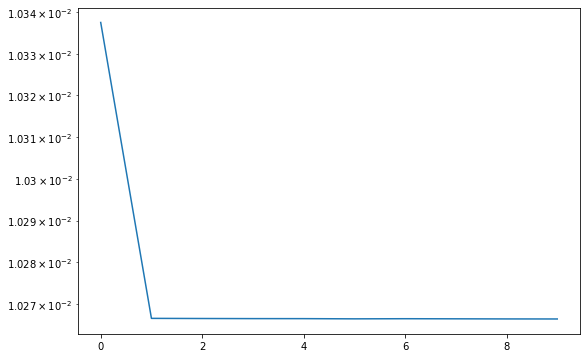

In [528]:
# Plot the error vs epochs
plt.plot(history.history['loss'])
plt.yscale('log')
plt.show()

# My implementation

## Some activation functions and error functions, and their derivatives

In [426]:
@njit(cache=False,fastmath=True)
def tanhOffsetAct(x):
    return 0.5*(1+np.tanh(x))

@njit(cache=False,fastmath=True)
def Sigmoid(x):
    return 1/(1+np.exp(-x))
#     return ne.evaluate('1/(1+exp(x))')

@njit(cache=False,fastmath=True)
def ReLU(x):
    return np.max(0,x)

@njit(cache=False,fastmath=True)
def Softmax1(x):
    """Compute the softmax of vector x."""
#     return np.exp(x) / np.sum(np.exp(x), axis=0)
#     More stable
    exps = np.exp(x - x.max())
    return exps / np.sum(exps, axis=0)

# correct solution:
@njit(cache=False,fastmath=True)  # Best implementation (VERY FAST)
def Softmax(x):
    """Works for 2D arrays only(rows for samples, columns for nodes/outputs)"""
    e_x = np.exp(x - np.max(x))
#     return e_x / e_x.sum(axis=1, keepdims=True) # only difference
    return e_x / e_x.sum(axis=1).reshape((-1, 1)) # Alternative of keepdims=True for Numba compatible

def SoftmaxAutoGrad(x):
    """Works for 2D arrays only(rows for samples, columns for outputs)"""
    e_x = anp.exp(x - anp.max(x))
    return e_x / e_x.sum(axis=1, keepdims=True) # only difference

# my (correct) solution:
def Softmax2(z):
    assert len(z.shape) == 2
    s = np.max(z, axis=1)
    s = s[:, np.newaxis] # necessary step to do broadcasting
    e_x = np.exp(z - s)
    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis] # dito
    return e_x / div

def Stable_softmax(x):
    '''Works for both 1d and 2d arrays'''
    z = x - np.max(x, axis=-1, keepdims=True)
    numerator = np.exp(z)
    denominator = np.sum(numerator, axis=-1, keepdims=True)
    softmax = numerator / denominator
    return softmax

In [498]:
@njit(cache=False,fastmath=True)
def errorFunc(outi, out0):
    '''
    Error function
    out0 is the expected output (exact/ideal)
    outi is the calculated output
    '''
    
    return np.sum((outi-out0)**2)/outi.shape[1]

def errorFunc_(outi, out0):
    '''
    Error function
    out0 is the expected output (exact/ideal)
    outi is the calculated output
    '''
    
    return anp.sum((outi-out0)**2)/outi.shape[1]

@njit(cache=False,fastmath=True)
def errorFuncGrad(outi, out0):
    '''
    Error function
    out0 is the expected output (exact/ideal)
    outi is the calculated output
    '''
    
    return 2*(outi-out0)/outi.shape[1]

@njit(cache=False,fastmath=True)
def tanhOffsetActFuncPrime(x):
    return 1/(np.cosh(2*x)+1)

@njit(cache=False,fastmath=True)
def Sigmoid_grad(x):
    return np.exp(-x)/(np.exp(-x)+1)**2
#     return ne.evaluate('exp(-x)/(exp(-x)+1)**2')

@njit(cache=False,fastmath=True)
def ReLU_grad(x):
    return np.max(0,x)

@njit(cache=False,fastmath=True)
def ReLUdActFuncPrime(x):
    return np.greater(z, 0).astype(int)
#     return return np.heaviside(x, 0)
#     return  (x > 0) * 1

@njit(cache=False,fastmath=True)
def SoftmaxActFuncPrime(x):
    s = x.reshape(-1,1)
    return np.diagflat(s) - np.dot(s, s.T)

# @njit(cache=False,fastmath=True)
def SoftmaxActFuncPrime1(x):
    x = softmax(x)
    s = x.reshape(-1,1)
    return np.diagflat(s) - np.dot(s, s.T)

# @njit(cache=False,fastmath=True)    
def Softmax_dash(x):
    '''Expects input to be an Nx1 2d array'''
    I = np.eye(x.shape[0])
    return softmax(x) * (I - softmax(x).T)

def SoftmaxActFuncPrime(x):
    signal = Softmax(x)
    J = - signal[..., None] * signal[:, None, :] # off-diagonal Jacobian
    iy, ix = np.diag_indices_from(J[0])
    J[:, iy, ix] = signal * (1. - signal) # diagonal
    return J.sum(axis=1) # sum across-rows for each sample

# @njit(cache=False,fastmath=True)  
def Softmax_d(x):
#     return softmax_broadcast(z) * (1 - softmax_broadcast(z))
    s = Softmax(x)
    return s * (1 - s)

def cross_ent(y, yhat):
    return -1 * np.sum(y * np.log(yhat+1e-16))

#def cross_entropy(predictions, targets, epsilon=1e-12):
#    """
#    Computes cross entropy between targets (encoded as one-hot vectors)
#    and predictions. 
#    Input: predictions (N, k) ndarray
#           targets (N, k) ndarray        
#    Returns: scalar
#    """
#    predictions = np.clip(predictions, epsilon, 1. - epsilon)
#    N = predictions.shape[0]
#    ce = -np.sum(targets*np.log(predictions+1e-9))/N
#    return ce

def cross_ent_d(y, yhat):
    return yhat - y

# @njit(cache=False,fastmath=True)  
def Softmax_broadcast(z):
    assert len(z.shape) == 2
    s = np.max(z, axis=1)
    s = s[:, np.newaxis] # necessary step to do broadcasting
    e_x = np.exp(z - s)
    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis] # dito
    return e_x / div

def Softmax_grad2(x): 
    # Take the derivative of softmax element w.r.t the each logit which is usually Wi * X
    # input s is softmax value of the original input x. 
    # s.shape = (1, n) 
    # i.e. s = np.array([0.3, 0.7]), x = np.array([0, 1])
    # initialize the 2-D jacobian matrix.
    s = softmax(x)
    jacobian_m = np.diag(s)
    for i in range(len(jacobian_m)):
        for j in range(len(jacobian_m)):
            if i == j:
                jacobian_m[i][j] = s[i] * (1-s[i])
            else: 
                jacobian_m[i][j] = -s[i]*s[j]
    return jacobian_m


def Softmax_jacob(x):
    s = Softmax(x)
    return np.einsum('ij,jk->ijk', s, np.eye(s.shape[-1])) - np.einsum('ij,ik->ijk', s, s)
#     return contract('ij,jk->ijk', s, np.eye(s.shape[-1])) - contract('ij,ik->ijk', s, s) #SLOWER

@njit(cache=False,fastmath=True)
def Softmax_grad(x): # Best implementation (VERY FAST)
    '''Returns the jacobian of the Softmax function for the given set of inputs.
    Inputs:
    x: should be a 2d array where the rows correspond to the samples
        and the columns correspond to the nodes.
    '''
    s = Softmax(x)
    a = np.eye(s.shape[-1])
    temp1 = np.zeros((s.shape[0], s.shape[1], s.shape[1]),dtype=np.float32)
    temp2 = np.zeros((s.shape[0], s.shape[1], s.shape[1]),dtype=np.float32)
    for i in range(s.shape[0]):
        for j in range(s.shape[1]):
            for k in range(s.shape[1]):
                temp1[i,j,k] = s[i,j]*a[j,k]
                temp2[i,j,k] = s[i,j]*s[i,k]
    return temp1-temp2

# @njit(cache=False,fastmath=True)
def Jsoftmax(X):
    sh = X.shape
    sm = Softmax(X)
    DM = sm.reshape(sh[0],-1,1) * np.diag(np.ones(sh[1])) # Diagonal matrices
#     OP = np.matmul(sm.reshape(sh[0],-1,1), sm.reshape(sh[0],1,-1)) # Outer products
#     OP = np.dot(sm.reshape(sh[0],-1,1), sm.reshape(sh[0],1,-1))
    OP = sm.reshape(sh[0],-1,1) @ sm.reshape(sh[0],1,-1)
    Jsm = DM - OP
    return Jsm


## Test softmax implementation vs tf.keras

In [485]:
temp = np.array([[1.,2.,3.,4.,5.],[1.,2.,3.,4.,5.]]).T
temp_tf = tf.convert_to_tensor(temp, dtype=tf.float32)
print(tf.keras.activations.softmax(temp_tf))
print(Softmax(temp))

print(Softmax(np.array([[1,2,3,4,5]],dtype=np.float32)))

tf.Tensor(
[[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]], shape=(5, 2), dtype=float32)
[[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]
[[0.01165623 0.03168492 0.08612854 0.23412167 0.6364086 ]]


## Test softmax gradient implementation 

In [486]:
# print(softmax_dash(temp))

print(SoftmaxActFuncPrime(temp))
print(Softmax_d(temp))
# print(softmax_grad2(temp))
print(Softmax_jacob(temp))
print(Jsoftmax(temp))
print(Softmax_d_numba(temp))
print(SoftmaxActFuncPrime1(temp))
Softmax_grad = jacobian(SoftmaxAutoGrad,0)
print(Softmax_grad(temp).reshape(10,10)) # Use the autograd library)

def tf_softmax_test(z):
  z = tf.constant(z, dtype=tf.float32)
  with tf.GradientTape() as g:
    g.watch(z)
    a = tf.nn.softmax(z) 
  jacob = g.batch_jacobian(a, z)
  return jacob.numpy()

print(tf_softmax_test(temp))

# print(softmaxActFuncPrime(np.array([1,2,3,4,5])))

# print(softmax_dash(np.array([1,2,3,4,5],dtype=np.float32)))



[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[0.25 0.25]
 [0.25 0.25]
 [0.25 0.25]
 [0.25 0.25]
 [0.25 0.25]]
[[[ 0.25 -0.25]
  [-0.25  0.25]]

 [[ 0.25 -0.25]
  [-0.25  0.25]]

 [[ 0.25 -0.25]
  [-0.25  0.25]]

 [[ 0.25 -0.25]
  [-0.25  0.25]]

 [[ 0.25 -0.25]
  [-0.25  0.25]]]
[[[ 0.25 -0.25]
  [-0.25  0.25]]

 [[ 0.25 -0.25]
  [-0.25  0.25]]

 [[ 0.25 -0.25]
  [-0.25  0.25]]

 [[ 0.25 -0.25]
  [-0.25  0.25]]

 [[ 0.25 -0.25]
  [-0.25  0.25]]]


NameError: name 'Softmax_d_numba' is not defined

In [52]:
%timeit Sigmoid(temp)

1.3 µs ± 21.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [53]:
%timeit Softmax(temp)

ff=Softmax(temp)

2.52 µs ± 232 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [54]:
%timeit Softmax_jacob(temp)

18.2 µs ± 2.27 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [55]:
%timeit Jsoftmax(temp)

18.8 µs ± 1.04 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [56]:
%timeit Softmax_d_numba(temp)

NameError: name 'Softmax_d_numba' is not defined

In [62]:
%timeit SigmoidActFuncPrime(temp)

NameError: name 'SigmoidActFuncPrime' is not defined

In [63]:
%timeit SoftmaxActFuncPrime1(temp)

NameError: name 'softmax' is not defined

## Choose if to use the error function grad defined manually or using the autograd

In [ ]:
# Define the gradient of the error function wrt to the predicted output values
gradErrorFunc = grad(errorFunc,0) # Use the autograd library
gradErrorFunc = errorFuncGrad

## Numba function to update weights as that is very slow (doesn't work)

In [ ]:
# @njit('float32, (float32[:]),(float32[:]), (float32[:]), (float32[:])',cache=False,fastmath=True, parallel=True)
@njit(cache=False,fastmath=True, parallel=False)
def updateWeightsBiases(eeta, weights, derWeights, biases, derBiases):
    newWeights = weights
    newBiases = biases
    for i in range(nLayers):
#         newWeights[i] = weights[i].astype('float32')-eeta*derWeights[i].astype('float32')
#         newBiases[i] = biases[i].astype('float32')-eeta*derBiases[i].astype('float32')
        newWeights[i] = weights[i]#.astype('float32')-eeta*derWeights[i].astype('float32')
        newBiases[i] = biases[i]#.astype('float32')-eeta*derBiases[i].astype('float32')
    return newWeights, newBiases

## Define forward feed, backpropagation and optimization functions

In [472]:
# @njit(cache=False,fastmath=True)
def forwardFeed(x, nLayers, biases, weights, activationFunc):
    '''
    x: matrix of input arrays of size mxn; m: samples/batch size; n: no. of inputs/features
    biases: 1d array of nLayers biases
    weights: nLayers matrices of weights
    '''
    # Forward feed begin
    a = [None] * (nLayers+1)
    z = [None] * nLayers
    a[0] = x
    for l in range(1,nLayers+1):
        z[l-1] = np.einsum('ij,kj->ik',a[l-1],weights[l-1])+biases[l-1] #np.dot(a[l-1],weights[l-1])#np.asarray(biases[l-1] + np.dot(a[l-1],weights[l-1])) #np.einsum('jk,k->j',weights[l-1],a[l-1])s #weights[l-1]*a[l-1]
#         z[l-1] = contract('ij,kj->ik',a[l-1],weights[l-1])+biases[l-1] #np.dot(a[l-1],weights[l-1])#np.asarray(biases[l-1] + np.dot(a[l-1],weights[l-1])) #np.einsum('jk,k->j',weights[l-1],a[l-1])s #weights[l-1]*a[l-1]
        actFunc_layer = act_func_dict[activationFunc[l-1]] #Activation function for this layer
        a[l] = actFunc_layer(z[l-1])
        
    return a, z

In [552]:
@njit(cache=False,fastmath=True,parallel=False)
def tempEval(a,b,n):
    out = np.empty((n,a.shape[1]),dtype=np.float32)
    for i in range(n):
#     for i in prange(n):
        out[i] = np.dot(a.T, b[i,:]).T
    return out

In [475]:
# @njit(cache=False,fastmath=True)
def backPropagation(z, a, sigmaPrime, nLayers, weights, dc_daL):
    '''
    z: list of input vectors (different sizes) at each layer
    a: list of output vectors after the application of act func (different sizes) at each layer
    sigmaPrime: the function that gives the derivative of the activation function
    dc_daL: a vector that gives the derivative of the Cost function wrt to the output
             vector coming out of the output layer
    '''
    nSamples = a[0].shape[0]
    delta = [None] * (nLayers+1)
    derWeights = [None] * nLayers
    derBiases = [None] * nLayers
    delta[nLayers] = sigmaPrime(z[nLayers-1])*dc_daL
    
    derWeights[nLayers-1] = np.einsum('ji,jk->ik',delta[nLayers],a[nLayers-1])
#     derWeights[nLayers-1] = contract('ji,jk->ik',delta[nLayers],a[nLayers-1])
    derBiases[nLayers-1] = np.sum(delta[nLayers],axis=0)
    
    for l in range(nLayers-1,0,-1):
        temp = np.array([np.dot(weights[l].T, delta[l+1][i,:]).T for i in range(nSamples)])
#         temp = tempEval(np.float32(weights[l]),np.float32(delta[l+1]),nSamples)
#         temp = np.dot(weights[l].T, list(delta[l+1].T)).T # Slower
        delta[l] = sigmaPrime(z[l-1])*temp
        derWeights[l-1] = np.einsum('ji,jk->ik',delta[l],a[l-1])
#         derWeights[l-1] = contract('ji,jk->ik',delta[l],a[l-1])
        derBiases[l-1] = np.asarray(np.sum(delta[l],axis=0))
    return derWeights, derBiases

In [476]:
# @njit(cache=False,fastmath=True)
def backPropagation2(z, a, sigmaPrime, nLayers, weights, dc_daL, opt_einsum_expr):
    '''
    z: list of input vectors (different sizes) at each layer
    a: list of output vectors after the application of act func (different sizes) at each layer
    sigmaPrime: the function that gives the derivative of the activation function
    dc_daL: a vector that gives the derivative of the Cost function wrt to the output
             vector coming out of the output layer
    '''
    nSamples = a[0].shape[0]
    delta = [None] * (nLayers+1)
    derWeights = [None] * nLayers
    derBiases = [None] * nLayers
    delta[nLayers] = sigmaPrime(z[nLayers-1])*dc_daL
    
    derWeights[nLayers-1] = opt_einsum_expr[0](delta[nLayers],a[nLayers-1])
#     derWeights[nLayers-1] = contract('ji,jk->ik',delta[nLayers],a[nLayers-1])
    derBiases[nLayers-1] = np.sum(delta[nLayers],axis=0)
    ioptexpr=1
    for l in range(nLayers-1,0,-1):
        temp = np.array([np.dot(weights[l].T, delta[l+1][i,:]).T for i in range(nSamples)])
#         temp = tempEval(np.float32(weights[l]),np.float32(delta[l+1]),nSamples)
#         temp = np.dot(weights[l].T, list(delta[l+1].T)).T # Slower
        delta[l] = sigmaPrime(z[l-1])*temp
        derWeights[l-1] = opt_einsum_expr[ioptexpr](delta[l],a[l-1])
        ioptexpr=ioptexpr+1
#         derWeights[l-1] = contract('ji,jk->ik',delta[l],a[l-1])
        derBiases[l-1] = np.asarray(np.sum(delta[l],axis=0))
    return derWeights, derBiases

In [551]:
@njit(cache=False,fastmath=True, parallel=False) #Works faster without tha parallel flag
def softmaxTimesVector(a,b):
    output = np.zeros((a.shape[0],a.shape[1]),dtype=np.float32)
    for i in prange(a.shape[0]):
#         a_temp = 
#         output[i,:] = np.dot(a[i,:,:], b[i,:]).T 
        output[i] = np.dot(a[i], b[i])
    return output

@njit(cache=False,fastmath=True)
def softmaxTimesVector2(a,b):
    output = np.zeros((a.shape[0],a.shape[1]),dtype=np.float32)
    for i in range(a.shape[0]):
#         a_temp = 
        output[i,:] = np.dot(a[i,:,:], b[i,:]).T 
#         output[i] = np.dot(a[i], b[i])
    return output

In [543]:
# @njit(cache=False,fastmath=True)
def backPropagation3(z, a, sigmaPrime, nLayers, nSamples, weights, biases, eeta, dc_daL):
    '''
    z: list of input vectors (different sizes) at each layer
    a: list of output vectors after the application of act func (different sizes) at each layer
    sigmaPrime: the function that gives the derivative of the activation function
    dc_daL: a vector that gives the derivative of the Cost function wrt to the output
             vector coming out of the output layer
    '''
    nSamples = a[0].shape[0]
    delta = [None] * (nLayers+1)
    derWeights = [None] * nLayers
    derBiases = [None] * nLayers

    sigmaPrime_layer = act_func_grad_dict[sigmaPrime[nLayers-1]] # Act func gradient for this layer
    if sigmaPrime[nLayers-1] =='Softmax':
        delta[nLayers] = softmaxTimesVector(sigmaPrime_layer(z[nLayers-1]).astype(np.float32),dc_daL.astype(np.float32))
    else:
        delta[nLayers] = sigmaPrime_layer(z[nLayers-1])*dc_daL

    newWeights = weights[:]#.copy()
    newBiases = biases[:]#.copy()
    
    derWeights[nLayers-1] = np.einsum('ji,jk->ik',delta[nLayers],a[nLayers-1])
    newWeights[nLayers-1] = weights[nLayers-1] - eeta*derWeights[nLayers-1]
#     derWeights[nLayers-1] = contract('ji,jk->ik',delta[nLayers],a[nLayers-1])
    derBiases[nLayers-1] = np.sum(delta[nLayers],axis=0)
    newBiases[nLayers-1] = biases[nLayers-1] - eeta*derBiases[nLayers-1]
    
    for l in range(nLayers-1,0,-1):
        temp = np.array([np.dot(weights[l].T, delta[l+1][i,:]).T for i in range(nSamples)])
#         temp = tempEval(np.float32(weights[l]),np.float32(delta[l+1]),nSamples)
#         temp = np.dot(weights[l].T, list(delta[l+1].T)).T # Slower
        sigmaPrime_layer = act_func_grad_dict[sigmaPrime[l-1]] # Act func gradient for this layer
        if sigmaPrime[l-1] =='Softmax':
            delta[l] = softmaxTimesVector(sigmaPrime_layer(z[l-1]).astype(np.float32),temp)
        else:    
            delta[l] = sigmaPrime_layer(z[l-1])*temp
#                 
        derWeights[l-1] = np.einsum('ji,jk->ik',delta[l],a[l-1])
#         derWeights[l-1] = contract('ji,jk->ik',delta[l],a[l-1])
        derBiases[l-1] = np.asarray(np.sum(delta[l],axis=0))
        newWeights[l-1] = weights[l-1] - eeta*derWeights[l-1] 
        newBiases[l-1] = biases[l-1] - eeta*derBiases[l-1]
    return derWeights, derBiases, newWeights, newBiases

In [546]:
# @njit(cache=False,fastmath=True)
def backPropagation4(z, a, sigmaPrime, nLayers, nSamples, weights, biases, eeta, dc_daL, opt_einsum_expr):
    '''
    z: list of input vectors (different sizes) at each layer
    a: list of output vectors after the application of act func (different sizes) at each layer
    sigmaPrime: the function that gives the derivative of the activation function
    dc_daL: a vector that gives the derivative of the Cost function wrt to the output
             vector coming out of the output layer
    '''
    nSamples = a[0].shape[0]
    delta = [None] * (nLayers+1)
    derWeights = [None] * nLayers
    derBiases = [None] * nLayers
    
    sigmaPrime_layer = act_func_grad_dict[sigmaPrime[nLayers-1]] # Act func gradient for this layer
    if sigmaPrime[nLayers-1] =='Softmax':
        delta[nLayers] = softmaxTimesVector(sigmaPrime_layer(z[nLayers-1]).astype(np.float32),dc_daL.astype(np.float32))
#         delta[nLayers] = softmaxTimesVector(sigmaPrime_layer(z[nLayers-1]),dc_daL)
    else:
        delta[nLayers] = sigmaPrime_layer(z[nLayers-1])*dc_daL
    
    newWeights = weights[:]#.copy()
    newBiases = biases[:]#.copy()
    
    derWeights[nLayers-1] = opt_einsum_expr[0](delta[nLayers],a[nLayers-1])
#     derWeights[nLayers-1] = contract('ji,jk->ik',delta[nLayers],a[nLayers-1])
    newWeights[nLayers-1] = weights[nLayers-1] - eeta*derWeights[nLayers-1]
    derBiases[nLayers-1] = np.sum(delta[nLayers],axis=0)
    newBiases[nLayers-1] = biases[nLayers-1] - eeta*derBiases[nLayers-1]
    ioptexpr=1
    for l in range(nLayers-1,0,-1):
        temp = np.array([np.dot(weights[l].T, delta[l+1][i,:]).T for i in range(nSamples)])
#         temp = tempEval(np.float32(weights[l]),np.float32(delta[l+1]),nSamples)
#         temp = tempEval(weights[l],delta[l+1],nSamples)
#         temp = np.dot(weights[l].T, list(delta[l+1].T)).T # Slower
        sigmaPrime_layer = act_func_grad_dict[sigmaPrime[l-1]] # Act func gradient for this layer
        if sigmaPrime[l-1] =='Softmax':
            delta[l] = softmaxTimesVector(sigmaPrime_layer(z[l-1]).astype(np.float32),temp)
#             delta[l] = softmaxTimesVector(sigmaPrime_layer(z[l-1]),temp)
        else:    
            delta[l] = sigmaPrime_layer(z[l-1])*temp
            
        derWeights[l-1] = opt_einsum_expr[ioptexpr](delta[l],a[l-1])
        ioptexpr=ioptexpr+1
#         derWeights[l-1] = contract('ji,jk->ik',delta[l],a[l-1])
        derBiases[l-1] = np.asarray(np.sum(delta[l],axis=0))
        newWeights[l-1] = weights[l-1] - eeta*derWeights[l-1] 
        newBiases[l-1] = biases[l-1] - eeta*derBiases[l-1]
    
    return derWeights, derBiases, newWeights, newBiases

In [548]:
def generateExpressions(nLayers, nSamples, z, a, dc_daL, sigmaPrime, weights):
    delta = [None] * (nLayers+1)
    opt_einsum_expr = []
    
    sigmaPrime_layer = act_func_grad_dict[sigmaPrime[nLayers-1]] # Act func gradient for this layer
    if sigmaPrime[nLayers-1] =='Softmax':
        delta[nLayers] = softmaxTimesVector(sigmaPrime_layer(z[nLayers-1]).astype(np.float32),dc_daL.astype(np.float32))
    else:
        delta[nLayers] = sigmaPrime_layer(z[nLayers-1])*dc_daL
        
    opt_einsum_expr.append(contract_expression('ji,jk->ik',delta[nLayers].shape,a[nLayers-1].shape))
    for l in range(nLayers-1,0,-1):
        temp = np.array([np.dot(weights[l].T, delta[l+1][i,:]).T for i in range(nSamples)])
        
        sigmaPrime_layer = act_func_grad_dict[sigmaPrime[l-1]] # Act func gradient for this layer
        if sigmaPrime[l-1] =='Softmax':
            delta[l] = softmaxTimesVector(sigmaPrime_layer(z[l-1]).astype(np.float32),temp)
        else:    
            delta[l] = sigmaPrime_layer(z[l-1])*temp
        
        opt_einsum_expr.append(contract_expression('ji,jk->ik',delta[l].shape,a[l-1].shape))
    return opt_einsum_expr

In [541]:
# @njit(cache=False,fastmath=True)
def neuralNetworkOptimize(nEpochs, batchSize, eeta, inputs, outputs, weights, biases, activationFunc, nLayers, errorFunc, gradErrorFunc,miniterEpoch=1,miniterBatch=100):
    errorPlot=[]
    forwardFeedDuration = 0.0
    backPropDuration = 0.0
    updateWeightsDuration = 0.0
    gradErrorDuration = 0.0
    nBatches = int(inputs.shape[0]/batchSize)
    
    for iEpoch in tqdm(range(nEpochs),leave=True,miniters=miniterEpoch):
        errorEpoch = 0.0
        for iBatch in tqdm(range(nBatches),leave=False,miniters=miniterBatch):
            offset = iBatch*batchSize
            x = inputs[offset:offset + batchSize,:]# Input vector
            outExpected = outputs[offset:offset + batchSize,:] # Expected output
#         start = timer()
            # Perform Forward feed and get the outputs at each layers and the inputs at each layer
            a, z = forwardFeed(x, nLayers, biases, weights, activationFunc)
#         forwardFeedDuration = forwardFeedDuration + timer() - start
   
            # Error
            errorBatch = errorFunc(a[nLayers],outExpected)
            # Average it over the samples in the batch
            errorEpoch += errorBatch/batchSize
    #         print('Error:\n', errorFunc(a[nLayers],outExpected))
        # Get the derivative of the output cost function wrt to the output vector of the output layer
        # The input arguments should always be an array
#         start = timer()
            dc_daL = gradErrorFunc(a[nLayers], outExpected)
            # Average it out
            dc_daL = dc_daL/batchSize
#         gradErrorDuration = gradErrorDuration + timer() - start
    #         print(dc_daL)
    #         print('Gradient of the error function wrt to the predicted output of the output layer\n',dc_daL)
            # Perform Back Propagation and get the derivatives wrt the weights and biases
#         start = timer()
            derWeights, derBiases, weights, biases = backPropagation3(z, a, activationFunc, nLayers, batchSize, weights, biases, eeta, dc_daL)
#         backPropDuration = backPropDuration + timer() - start
  


        # Average over the batches
        errorPlot.append(errorEpoch/nBatches)
        
        if(iEpoch==0):
            print('Average Error with initial weights and biases:', errorEpoch/nBatches)
    
    
    return weights, biases, errorPlot

In [549]:
# @njit(cache=False,fastmath=True)
def neuralNetworkOptimize2(nEpochs, batchSize, eeta, inputs, outputs, weights, biases, activationFunc, nLayers, errorFunc, gradErrorFunc,miniterEpoch=1,miniterBatch=100):
    errorPlot=[]
    nBatches = int(inputs.shape[0]/batchSize)
    for iEpoch in tqdm(range(nEpochs),leave=True,miniters=miniterEpoch):
        errorEpoch = 0.0
        for iBatch in tqdm(range(nBatches),leave=False,miniters=miniterBatch):
            offset = iBatch*batchSize
            x = inputs[offset:offset + batchSize,:]# Input vector
          
            outExpected = outputs[offset:offset + batchSize,:] # Expected output
            # Perform Forward feed and get the outputs at each layers and the inputs at each layer
            a, z = forwardFeed(x, nLayers, biases, weights, activationFunc)
          
        
            # Error
            errorBatch = errorFunc(a[nLayers],outExpected)
            # Average it over the samples in the batch
            errorEpoch += errorBatch/batchSize
            # Get the derivative of the output cost function wrt to the output vector of the output layer
            # The input arguments should always be an array
            dc_daL = gradErrorFunc(a[nLayers], outExpected)
            # Average it out
            dc_daL = dc_daL/batchSize
            if iEpoch==0 and iBatch==0:
                opt_expr = generateExpressions(nLayers, batchSize, z, a, dc_daL, activationFunc, weights)
   
            # Perform Back Propagation and get the derivatives wrt the weights and biases
            derWeights, derBiases, weights, biases = backPropagation4(z, a, activationFunc, nLayers, batchSize, weights, biases, eeta, dc_daL,opt_expr)



        # Average over the batches
        errorPlot.append(errorEpoch/nBatches)
        
        if(iEpoch==0):
            print('Average Error with initial weights and biases:', errorEpoch/nBatches)
    

        
    return weights, biases, errorPlot

## Forwad feed once

In [264]:
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forwardFeed(inputs, nLayers, biasesOriginal, weightsOriginal, sigmoid)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)

# Error
print('Error:\n', errorFunc(a[nLayers],outputs)/batchSizenBatch)

NameError: name 'sigmoid' is not defined

## Backpropagation

In [32]:
# Get the derivative of the output cost function wrt to the output vector of the output layer
# The input arguments should always be an array
dc_daL = gradErrorFunc(a[nLayers], outputs)/batchSizenBatch
print('Gradient of the error function wrt to the predicted output of the output layer\n',dc_daL)

# Perform Back Propagation and get the derivatives wrt the weights and biases
derWeights, derBiases = backPropagation(z, a, sigmoidActFuncPrime, nLayers, weightsOriginal, dc_daL)
print('Gradient of Cost (error function) wrt weights:\n',derWeights)
print('Gradient of Cost (error function) wrt biases:\n',derBiases)

Gradient of the error function wrt to the predicted output of the output layer
 [[ 0.00406454  0.00253283 -0.00403984 ...  0.00420075  0.00347823
   0.00448038]
 [ 0.00394192  0.00235103  0.00220455 ...  0.00414007  0.00334958
   0.00445756]
 [ 0.00379844  0.0025399   0.00210869 ...  0.00404181  0.00363503
   0.00409809]
 ...
 [ 0.0037117   0.00233587  0.00230286 ...  0.00422685  0.0037155
   0.00412504]
 [ 0.0037117   0.00233587  0.00230286 ...  0.00422685  0.0037155
   0.00412504]
 [ 0.0037117   0.00233587  0.00230286 ...  0.00422685  0.0037155
   0.00412504]]
Gradient of Cost (error function) wrt weights:
 [array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[26.867386, 26.867434, 26.868979, 26.86529 , 26.865046, 26.864662,
        26.865828, 26.865627, 26.86419 , 26.864515]

## Gradient descent (update the weights and biases)

In [33]:
newWeights = [weightsOriginal[i] - eeta*derWeights[i] for i in range(nLayers)]
print('New Weights: ', newWeights)

newBiases = [biasesOriginal[i] - eeta*derBiases[i] for i in range(nLayers)]
# newBiases = biasesOriginal
print('New Biases: ', newBiases)

New Weights:  [array([[ 0.03627518,  0.03873832,  0.08149163, ..., -0.02127501,
         0.0154087 , -0.06386789],
       [ 0.07440593, -0.04087887,  0.01924989, ...,  0.08657975,
         0.08116265,  0.05715742],
       [ 0.01158784, -0.06334922,  0.05219064, ...,  0.08594594,
         0.04217721,  0.02432594],
       ...,
       [ 0.03304923, -0.00221176,  0.04806163, ...,  0.00660336,
         0.08642668,  0.08179801],
       [-0.00772075, -0.00126788, -0.02203689, ...,  0.08539135,
        -0.04701928,  0.0844337 ],
       [ 0.04903596,  0.00070376, -0.028322  , ..., -0.01517832,
        -0.04009866,  0.06483103]], dtype=float32), array([[-13.016    , -13.607815 , -12.9008045, -13.064295 , -13.890092 ,
        -13.764267 , -13.420746 , -13.2557745, -13.141981 , -13.507717 ],
       [ -8.699139 ,  -7.681697 ,  -8.490524 ,  -8.500596 ,  -8.382329 ,
         -8.7226515,  -8.367085 ,  -7.9175897,  -8.652409 ,  -7.6562243],
       [ -8.536556 ,  -8.200025 ,  -7.5229692,  -8.43951  ,  -

## Forward feed again and check the loss/error

In [34]:
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forwardFeed(inputs, nLayers, newBiases, newWeights, sigmoid)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)

# New Error
print('New Error:\n', errorFunc(a[nLayers],outputs)/batchSizenBatch)

Outputs at each layer (including input layer):
  [array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[1.0240552e-01, 5.7284073e-03, 1.3237169e-06, ..., 3.4698860e-03,
        3.8896427e-02, 9.9398220e-01],
       [9.0327583e-02, 4.6089860e-03, 1.1277501e-06, ..., 1.7556654e-03,
        6.6245064e-02, 9.9436784e-01],
       [1.2938139e-01, 4.4990522e-03, 5.8876071e-07, ..., 3.6708240e-03,
        1.4981900e-02, 9.9024034e-01],
       ...,
       [8.5810743e-02, 3.5445304e-03, 6.1407906e-07, ..., 3.0162397e-03,
        4.1916396e-02, 9.8952925e-01],
       [8.5810743e-02, 3.5445304e-03, 6.1407906e-07, ..., 3.0162397e-03,
        4.1916396e-02, 9.8952925e-01],
       [8.5810743e-02, 3.5445304e-03, 6.1407906e-07, ..., 3.0162397e-03,
        4.1916396e-02, 9.8952925e-01]], dtype=fl

## ** With np.einsum (slightly Slower than opt_einsum expression reuse)**

In [427]:
%%time

# Run optimization
optWeights, optBiases, errorPlot = neuralNetworkOptimize(nEpochs, batchSize, eeta, inputs, outputs, weightsOriginal, biasesOriginal, activation_func_names, nLayers, errorFunc, gradErrorFunc,miniterEpoch=1,miniterBatch=100)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Average Error with initial weights and biases: 0.010044901712338109


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

CPU times: user 6min 56s, sys: 2.34 s, total: 6min 58s
Wall time: 7min 11s


In [428]:
print(errorPlot)

[0.010044901712338109, 0.010042903963724852, 0.010042898127238069, 0.010042891929944299, 0.010042886000076892, 0.010042879887819404, 0.010042874168157512, 0.010042868044773648, 0.01004286225914965, 0.010042856178283691]


In [429]:
print(errorPlot)

[0.010044901712338109, 0.010042903963724852, 0.010042898127238069, 0.010042891929944299, 0.010042886000076892, 0.010042879887819404, 0.010042874168157512, 0.010042868044773648, 0.01004286225914965, 0.010042856178283691]


#### Test the quality of the weights by running a forward feed again

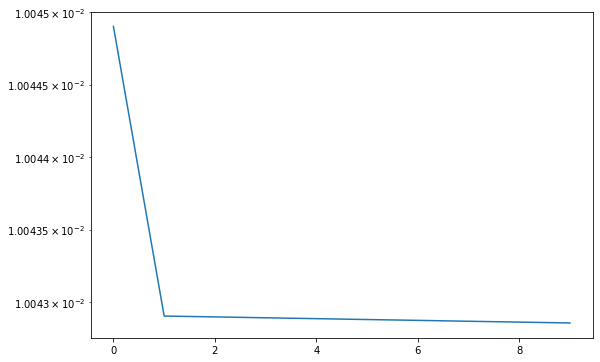

In [430]:
# Plot the error vs epochs
plt.plot(errorPlot)
plt.yscale('log')
plt.show()

In [431]:
# Optimized weights and biases
print('Optimized Weights: ', optWeights)
print('Optimized Biases: ', optBiases)
# Forward feed with optimized weights
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forwardFeed(inputs, nLayers, optBiases, optWeights, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)
# New Error
print('New Average Error with optimized weights:\n', errorFunc(a[nLayers],outputs)/nBatch)
print('Input: ',inputs)
print('Output: ',a[nLayers])
print('Expected Output: ',outputs)

Optimized Weights:  [array([[-0.03687183, -0.02200101, -0.01517013, ...,  0.05941518,
        -0.00997759, -0.05189016],
       [ 0.04746704,  0.01575129, -0.02311385, ...,  0.03787632,
        -0.03036439, -0.04755063],
       [-0.00239056,  0.04121918, -0.00514909, ...,  0.01835155,
        -0.01352269,  0.01097737],
       ...,
       [-0.00158566, -0.04985555,  0.03384705, ...,  0.03755527,
        -0.0013184 ,  0.02485457],
       [-0.01005903,  0.01377036,  0.05807677, ..., -0.0063571 ,
        -0.06040018, -0.0098046 ],
       [-0.01228685, -0.05192744,  0.0531431 , ...,  0.05982278,
        -0.0150273 ,  0.01909861]], dtype=float32), array([[ 0.02498787,  0.05732275, -0.0306751 , ..., -0.02181369,
        -0.01512767,  0.02028212],
       [-0.05025196, -0.00805017,  0.06102042, ..., -0.00970942,
         0.05370441,  0.05645059],
       [-0.04009592, -0.05008802, -0.04357262, ...,  0.02021527,
        -0.03910119, -0.00472011],
       ...,
       [-0.03505543, -0.00117416,  0.0

Outputs at each layer (including input layer):
  [array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[0.40231487, 0.52511   , 0.5669279 , ..., 0.5989115 , 0.35440716,
        0.5360525 ],
       [0.57300603, 0.52784806, 0.5645102 , ..., 0.5641259 , 0.49842754,
        0.53669983],
       [0.36779088, 0.5043511 , 0.55113035, ..., 0.498008  , 0.53999263,
        0.40183988],
       ...,
       [0.49999684, 0.500014  , 0.5000061 , ..., 0.5000028 , 0.50000477,
        0.5000053 ],
       [0.49999684, 0.500014  , 0.5000061 , ..., 0.5000028 , 0.50000477,
        0.5000053 ],
       [0.49999684, 0.500014  , 0.5000061 , ..., 0.5000028 , 0.50000477,
        0.5000053 ]], dtype=float32), array([[0.6110536 , 0.6131122 , 0.5228846 , ..., 0.6271261 , 0.34808645,
        0.6337966 ],
      

In [432]:
print('Difference b/w our weights & biases and keras results:')
for i in range(nLayers):
    print('\nLayer : ',i+1)
    print(abs(optWeights[i]-model.layers[i].get_weights()[0].T).max())
    print(abs(optBiases[i]-model.layers[i].get_weights()[1].T).max())

Difference b/w our weights & biases and keras results:

Layer :  1
1.7149374e-05
2.6913613e-06

Layer :  2
1.1550728e-05
5.1951197e-06

Layer :  3
0.00010564923
0.00012251828


## ** NEW METHOD ** With opt_einsum expressions (It is faster than np.einsum but only slightly)

In [572]:
%%time
# Run optimization
optWeights, optBiases, errorPlot = neuralNetworkOptimize2(nEpochs, batchSize, eeta, inputs, outputs, weightsOriginal, biasesOriginal, activation_func_names, nLayers, errorFunc, gradErrorFunc,miniterEpoch=1,miniterBatch=100)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Average Error with initial weights and biases: 0.01033708187421161


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 2min 58s, sys: 717 ms, total: 2min 58s
Wall time: 2min 59s


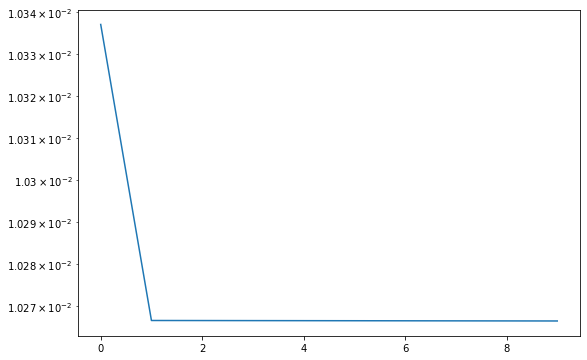

In [553]:
# Plot the error vs epochs
plt.plot(errorPlot)
plt.yscale('log')
plt.show()

In [554]:
# Optimized weights and biases
print('Optimized Weights: ', optWeights)
print('Optimized Biases: ', optBiases)
# Forward feed with optimized weights
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forwardFeed(inputs, nLayers, optBiases, optWeights, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)
# New Error
print('New Average Error with optimized weights:\n', errorFunc(a[nLayers],outputs)/batchSize)
print('Input: ',inputs)
print('Output: ',a[nLayers])
print('Expected Output: ',outputs)

Optimized Weights:  [array([[-0.02419456, -0.01163159,  0.02475894, ...,  0.03824916,
         0.0274745 , -0.05233389],
       [-0.03639057,  0.0452029 ,  0.05432296, ..., -0.04163023,
         0.02325216, -0.03995981],
       [-0.0261796 ,  0.03212485, -0.01673191, ..., -0.05381735,
        -0.01957689, -0.03536157],
       ...,
       [ 0.04830931,  0.00063124,  0.05744867, ...,  0.00549434,
         0.05184112, -0.03123657],
       [-0.02347935,  0.02467095,  0.0040729 , ...,  0.00690878,
         0.05925937,  0.04053029],
       [-0.04591497,  0.02918391, -0.00739492, ...,  0.02302977,
        -0.01469268, -0.03318025]], dtype=float32), array([[ 0.04592408, -0.05403687,  0.01865016, ..., -0.01508478,
        -0.01780727,  0.03647115],
       [-0.05094783, -0.02825568,  0.00542623, ...,  0.02848225,
         0.05764061, -0.04098406],
       [ 0.05919029,  0.03909305,  0.01487921, ...,  0.00447792,
         0.05657365,  0.0213086 ],
       ...,
       [-0.00600216,  0.0234836 ,  0.0

Outputs at each layer (including input layer):
  [array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[0.46489528, 0.5558503 , 0.52944547, ..., 0.48490363, 0.5457236 ,
        0.6162003 ],
       [0.3319804 , 0.5697266 , 0.5153509 , ..., 0.39351648, 0.49685228,
        0.6160668 ],
       [0.38659927, 0.5062168 , 0.50196105, ..., 0.49845362, 0.47856435,
        0.5302924 ],
       ...,
       [0.49999362, 0.50000983, 0.50000185, ..., 0.49999344, 0.5000023 ,
        0.5000055 ],
       [0.49999362, 0.50000983, 0.50000185, ..., 0.49999344, 0.5000023 ,
        0.5000055 ],
       [0.49999362, 0.50000983, 0.50000185, ..., 0.49999344, 0.5000023 ,
        0.5000055 ]], dtype=float32), array([[0.498897  , 0.5172212 , 0.70840245, ..., 0.46187803, 0.68078667,
        0.72219825],
      

In [555]:
print('Difference b/w our weights & biases and keras results:')
for i in range(nLayers):
    print('\nLayer : ',i+1)
    print(abs(optWeights[i]-model.layers[i].get_weights()[0].T).max())
    print(abs(optBiases[i]-model.layers[i].get_weights()[1].T).max())

Difference b/w our weights & biases and keras results:

Layer :  1
2.8207898e-05
2.8239883e-06

Layer :  2
2.5391579e-05
8.388139e-06

Layer :  3
0.00018656068
2.77426e-05


# PyTorch

In [556]:
### Choose device: 'cuda' or 'cpu'
device = 'cpu'
# device = 'cuda'

## Generate the network programatically

## Method 1

In [557]:
Layers = []
# Input layer
Layers.append(torch.nn.Linear(nInputs, neurons_per_layer[0]))
Layers.append(torch.nn.Sigmoid())

if nLayers>1:
    # Hidden layers
    for i in range(1,nLayers-1):
        Layers.append(torch.nn.Linear(neurons_per_layer[i-1], neurons_per_layer[i]))
        Layers.append(torch.nn.Sigmoid())
    # Output layer
    Layers.append(torch.nn.Linear(neurons_per_layer[nLayers-2], neurons_per_layer[nLayers-1]))
    Layers.append(torch.nn.Sigmoid())

In [558]:
Network = torch.nn.Sequential(*Layers)

In [559]:
print(Network)

Sequential(
  (0): Linear(in_features=784, out_features=700, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=700, out_features=700, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=700, out_features=10, bias=True)
  (5): Sigmoid()
)


## Method 2 (Suitable for us to modify weights for each layer to be same as keras and my implementation)

In [560]:
Network = torch.nn.Sequential()
 
# Input layer -> 1st hidden layer
Network.add_module(str(0),torch.nn.Linear(nInputs, neurons_per_layer[0]))
# Activation function after first hidden layer
Network.add_module('act0',act_func_dict_PyTorch[activation_func_names[0]])

if nLayers>1:
    # Hidden layers
    for i in range(1,nLayers-1):
        Network.add_module(str(i),torch.nn.Linear(neurons_per_layer[i-1], neurons_per_layer[i]))
        Network.add_module('act'+str(i),act_func_dict_PyTorch[activation_func_names[i]])
        
    # Output layer
    Network.add_module(str(nLayers-1),torch.nn.Linear(neurons_per_layer[nLayers-2], neurons_per_layer[nLayers-1]))
    Network.add_module('act'+str(nLayers-1),act_func_dict_PyTorch[activation_func_names[nLayers-1]])

In [561]:
# torch.nn.init.constant_(Network.weight, 2.0)
Network.to(device=device)

Sequential(
  (0): Linear(in_features=784, out_features=700, bias=True)
  (act0): Sigmoid()
  (1): Linear(in_features=700, out_features=700, bias=True)
  (act1): Sigmoid()
  (2): Linear(in_features=700, out_features=10, bias=True)
  (act2): Softmax(dim=1)
)

## initial weights and biases generated by Pytorch

In [562]:
print(Network[0].weight)
print(Network[0].bias)

Parameter containing:
tensor([[-0.0045,  0.0144,  0.0123,  ...,  0.0005, -0.0216, -0.0285],
        [-0.0143, -0.0313,  0.0102,  ...,  0.0176,  0.0203,  0.0160],
        [ 0.0173,  0.0311, -0.0155,  ..., -0.0079,  0.0026, -0.0041],
        ...,
        [-0.0303,  0.0004, -0.0130,  ...,  0.0166, -0.0106,  0.0119],
        [-0.0251, -0.0065,  0.0023,  ...,  0.0299, -0.0053,  0.0056],
        [-0.0016, -0.0082, -0.0006,  ..., -0.0313, -0.0101, -0.0123]],
       requires_grad=True)
Parameter containing:
tensor([ 1.4961e-02,  3.0201e-02,  1.6075e-02,  7.4827e-03,  1.8506e-02,
        -1.9486e-02, -1.0998e-02, -3.0491e-02,  9.1714e-03,  3.2394e-02,
         8.8166e-04, -1.4355e-03,  3.4286e-02, -3.0075e-02,  2.4523e-02,
         2.1781e-02, -1.7177e-02, -1.2518e-02,  3.0764e-02, -1.0864e-02,
         1.1142e-02,  3.5681e-02,  5.5270e-04,  1.9132e-02,  2.1600e-03,
         3.5034e-03, -4.2190e-03, -2.9543e-02,  1.9607e-02,  1.7608e-02,
         2.6700e-03,  1.8317e-02,  8.6844e-03, -1.4231e-0

## Change them to be the same as others

## **IMPORTANT NOTE**: The returned tensor and the original array share the same memory. So any changes to the tensor change the array as well.

Reference: https://pytorch.org/docs/stable/generated/torch.from_numpy.html



In [563]:
for i in range(nLayers):
    # Weights
#     Network._modules[str(i)].weight.data = torch.from_numpy(weightsOriginal[i]).to(dtype=torch.float32)
    Network._modules[str(i)].weight.data = torch.tensor(weightsOriginal[i]).to(dtype=torch.float32)
    # Biases
#     Network._modules[str(i)].bias.data = torch.from_numpy(biasesOriginal[i]).to(dtype=torch.float32) # Convert to float32
    Network._modules[str(i)].bias.data = torch.tensor(biasesOriginal[i]).to(dtype=torch.float32) # Convert to float32

In [564]:
for i in range(nLayers):
    # Weights
    print('Weights:\n')
    print(Network._modules[str(i)].weight.data)
    # Biases
    print('Biases:\n')
    print(Network._modules[str(i)].bias.data)

Weights:

tensor([[-0.0242, -0.0116,  0.0248,  ...,  0.0382,  0.0275, -0.0523],
        [-0.0364,  0.0452,  0.0543,  ..., -0.0416,  0.0233, -0.0400],
        [-0.0262,  0.0321, -0.0167,  ..., -0.0538, -0.0196, -0.0354],
        ...,
        [ 0.0483,  0.0006,  0.0574,  ...,  0.0055,  0.0518, -0.0312],
        [-0.0235,  0.0247,  0.0041,  ...,  0.0069,  0.0593,  0.0405],
        [-0.0459,  0.0292, -0.0074,  ...,  0.0230, -0.0147, -0.0332]])
Biases:

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.,

In [565]:
### Get information about model
totpars = 0
for par in Network.parameters():
    newpars = 1
    for num in par.shape:
        newpars *= num
    totpars += newpars
print(Network)
print('%i trainable parameters' % totpars)

### Initialize loss function and optimizer
# crit = torch.nn.BCELoss()
# opt = torch.optim.SGD(Network.parameters(), lr=0.2)

crit = torch.nn.MSELoss()
opt = torch.optim.SGD(Network.parameters(), lr=eeta)

Sequential(
  (0): Linear(in_features=784, out_features=700, bias=True)
  (act0): Sigmoid()
  (1): Linear(in_features=700, out_features=700, bias=True)
  (act1): Sigmoid()
  (2): Linear(in_features=700, out_features=10, bias=True)
  (act2): Softmax(dim=1)
)
1047210 trainable parameters


In [566]:
inputsTorch = torch.from_numpy(inputs)
inputsTorch = inputsTorch.to(dtype=torch.float32) # Convert to float32
labels = torch.from_numpy(outputs)
labels = labels.to(dtype=torch.float32) # Convert to float32

In [567]:
print(inputsTorch)
print(labels)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [571]:
%%time
### Set model in training mode and create the epochs axis
Network.train()
epochs = range(1, nEpochs+1)
errorPlot = []

### Train the model
for e in tqdm(epochs):
    tr_loss = 0.
    samples = 0
    ### Loop over batches
    for iBatch in tqdm(range(nBatches),leave=False):
        offset = iBatch*batchSize
        inputsBatch = inputsTorch[offset:offset + batchSize,:]# Input vector
#            print(x.shape)
        labelsBatch = labels[offset:offset + batchSize,:] # Expected output
        
        opt.zero_grad() # zero gradient values
        inputsBatch = inputsBatch.to(device=device) # move input and label tensors to the device with the model
        labelsBatch = labelsBatch.to(device=device)
        outputsTorch = Network(inputsBatch) # compute model outputs
        loss = crit(outputsTorch, labelsBatch) # compute batch loss
        loss.backward() # back-propagate the gradients
        opt.step() # update the model weights
        tr_loss += loss.clone().cpu().item()*len(inputsBatch) # add the batch loss to the running loss
        samples += len(inputsBatch) # update the number of processed samples
    tr_loss /= samples # compute training loss
    errorPlot.append(tr_loss)
    print(e, tr_loss)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

1 0.010265769402806957


  0%|          | 0/300 [00:00<?, ?it/s]

2 0.010265754777938127


  0%|          | 0/300 [00:00<?, ?it/s]

3 0.010265740168591341


  0%|          | 0/300 [00:00<?, ?it/s]

4 0.01026572565548122


  0%|          | 0/300 [00:00<?, ?it/s]

5 0.010265711192041636


  0%|          | 0/300 [00:00<?, ?it/s]

6 0.010265696722393235


  0%|          | 0/300 [00:00<?, ?it/s]

7 0.010265682442113757


  0%|          | 0/300 [00:00<?, ?it/s]

8 0.010265667550265789


  0%|          | 0/300 [00:00<?, ?it/s]

9 0.010265652745341261


  0%|          | 0/300 [00:00<?, ?it/s]

10 0.010265638157725333
CPU times: user 1min 5s, sys: 2.6 s, total: 1min 8s
Wall time: 57.2 s


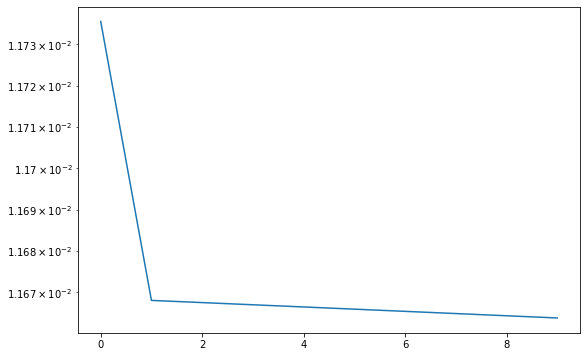

In [569]:
# Plot the error vs epochs
plt.plot(errorPlot)
plt.yscale('log')
plt.show()

In [570]:
print('Difference b/w our weights & biases and PyTorch results:')
for i in range(nLayers):
    print('\nLayer : ',i+1)
    print(abs(torch.tensor(optWeights[i]).to(dtype=torch.float32)-Network._modules[str(i)].weight.data).max())
    print(abs(torch.tensor(optBiases[i]).to(dtype=torch.float32)-Network._modules[str(i)].bias.data).max())

Difference b/w our weights & biases and PyTorch results:

Layer :  1
tensor(0.0008)
tensor(4.4266e-05)

Layer :  2
tensor(0.0005)
tensor(7.0852e-05)

Layer :  3
tensor(0.0021)
tensor(6.5390e-05)


In [402]:
torch.get_num_threads()

4

In [289]:
torch.set_num_threads(4)
torch.get_num_threads()

4

In [1579]:
torch.get_num_threads()

1